# Visualize MRI images
The purpose of this notebook is to visualize the given MRI image data we have, this will help us better understand what data we are dealing with and construct the modeling approach

In [1]:
import pandas as pd
#import torchio
import tarfile
import torch
import os
import matplotlib.pyplot as plt

### model
#from GlobalLocalTransformer3D_multiscale import GlobalLocalBrainAge

from google.colab import drive
drive.mount('/content/drive')

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Mounted at /content/drive


device(type='cpu')

## Step 1: Define CustomDataset to load the data

In [2]:
import os
import nibabel as nib
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []

        # Iterate over each fold
        for fold in os.listdir(self.root_dir):
            fold_dir = os.path.join(self.root_dir, fold)
            #print(fold)
            if fold=="SchizConnect_Patient_info":
              continue
              #do nothing
            else:
              # Check if it's a directory
              if os.path.isdir(fold_dir):
                a = os.listdir(fold_dir)
                folder_name_in_fold_i = a[0]
                fold_dir = os.path.join(fold_dir, folder_name_in_fold_i)
                # Iterate over CN and schiz folders
                for category in ['CN', 'schiz']:
                    category_dir = os.path.join(fold_dir, category)
                    if category == "CN":
                      Category_num = 0
                    else:
                      Category_num = 1

                    # Check if the category folder exists
                    if os.path.isdir(category_dir):
                        # Iterate over image files
                        for file in os.listdir(category_dir):
                            file_path = os.path.join(category_dir, file)
                            # Append sample tuple (image path, fold, category) to the list

                            ############## Get the source of the image
                            # Find the index of the 7th and 8th appearance of "_"
                            count = 0
                            seventh_index = -1
                            eighth_index = -1
                            for i, char in enumerate(file):
                                if char == "_":
                                    count += 1
                                    if count == 7:
                                        seventh_index = i
                                    if count == 8:
                                        eighth_index = i
                                        break
                            #extract the text between the 7th and 8th apperance of "_"
                            source = file[seventh_index + 1:eighth_index]
                            samples.append((file_path, fold, source, Category_num))

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, fold, source, category = self.samples[idx]

        # Load the NIfTI image
        img = nib.load(file_path)

        # Get the image data array
        img_data = img.get_fdata()

        # Convert to PyTorch tensor
        img_tensor = torch.tensor(img_data, dtype=torch.float32)

        return img_tensor, fold, source, category

    def display_image(self, idx, show_image = True):
        file_path, fold, source, category = self.samples[idx]
        if category == 0:
          category = "CN"
        else:
          category = "schiz"
        # Load the NIfTI image
        img = nib.load(file_path)

        # Get the image data array
        img_data = img.get_fdata()

        # Display one of the slices (e.g., middle slice along the first dimension)
        slice_num = img_data.shape[0] // 2  # Get the middle slice
        slice_data = img_data[slice_num, :, :]  # Extract the slice data

        # Plot the slice
        if show_image:
          plt.imshow(slice_data, cmap='gray')
          plt.axis('off')  # Turn off axis labels
          plt.title(f'MRI Image\n Class: {category}, Source: {source}')
          #plt.subtitle(f"Class: {category}, Source: {source}")
          plt.show()
        return slice_data


## Use the CustomDataset to load the images
Note: you should change the root_dir in the following chunk to the path that contains the data

Image shape: torch.Size([193, 229, 193])


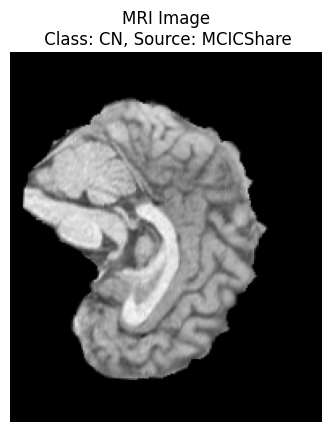

In [3]:
# Define the root directory where your data is located
try:
  root_dir = "/content/drive/MyDrive/BME Project/Data/SCZ classification"
  # Create an instance of the dataset
  dataset = CustomDataset(root_dir)
except:
  root_dir= "/content/drive/MyDrive/BME Project/data"
  dataset = CustomDataset(root_dir)

# Accessing an individual sample
# sample_idx = 1
# img_tensor, fold, category = dataset[sample_idx]
id_of_image_to_present = 101
print("Image shape:",dataset[id_of_image_to_present][0].shape)
sample_image_array = dataset.display_image(id_of_image_to_present)

## Let's see the MRI images we have
The following chunk will enable displaying some slices of the brain MRI image. Note that we can take the slices from different angels, we will see how slices from different angles looks like

Displaying slices from image index: 20


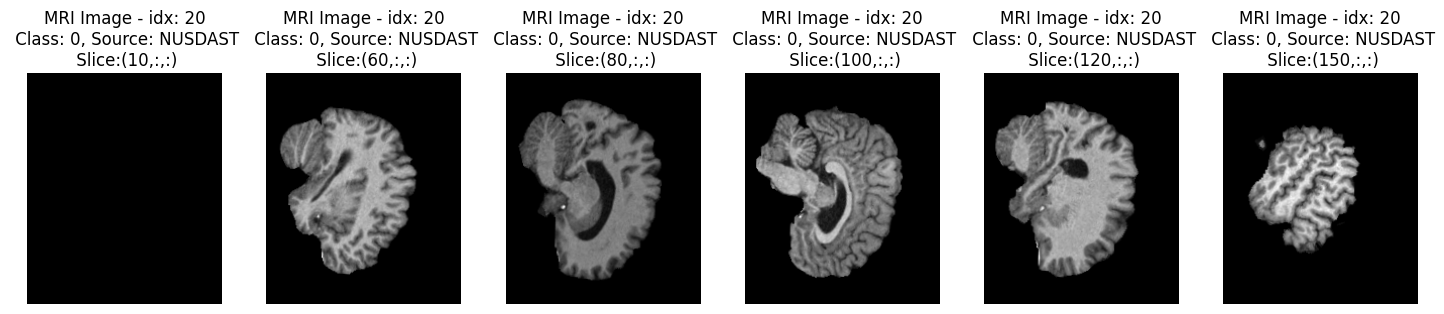

Displaying slices from image index: 40


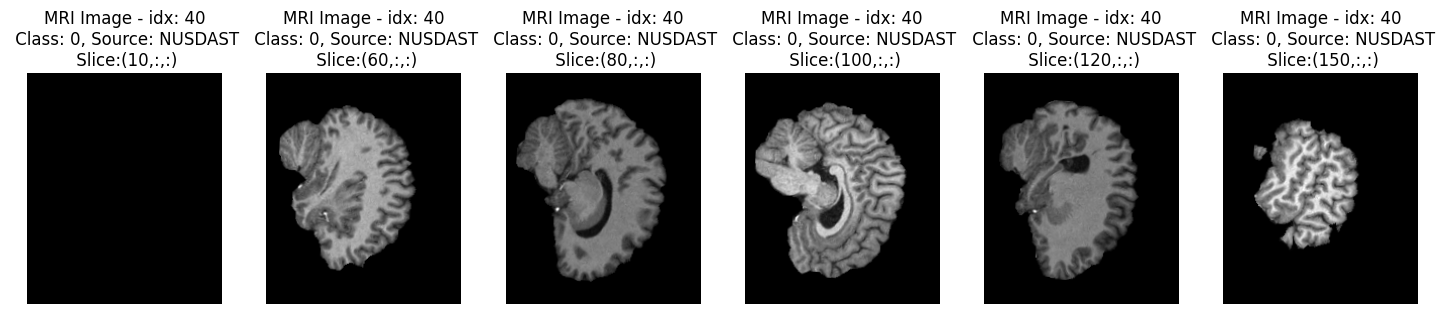

Displaying slices from image index: 60


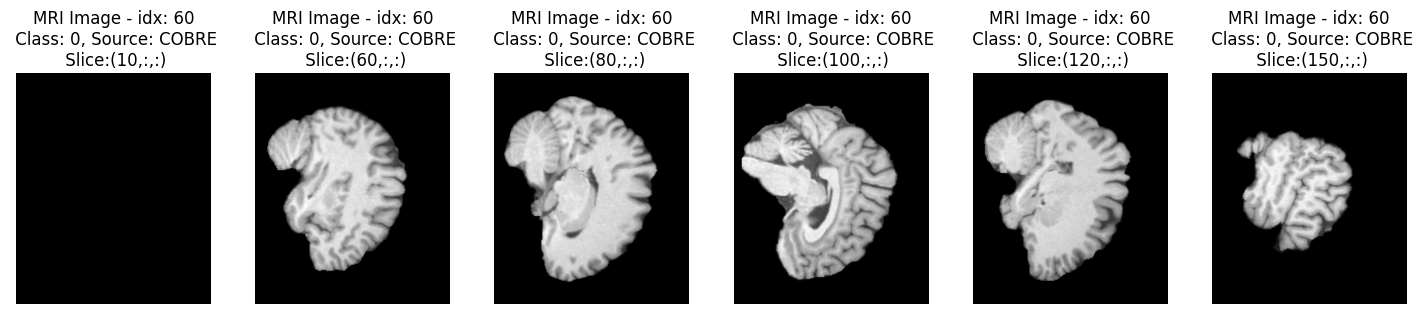

In [8]:
# Assuming list_slices is a list of slice indices you want to present
ids_to_present = [20, 40, 60]
list_slices = [10, 60, 80, 100, 120, 150]  # Example list of slices

for id_of_image_to_present in ids_to_present:
  print("Displaying slices from image index:",id_of_image_to_present)
  img_data, fold, source, category = dataset[id_of_image_to_present]
  plt.figure(figsize=(18, 3))  # Adjust figure size as needed
  for i, slice_index in enumerate(list_slices):
      slice_data = img_data[slice_index, :, :]  # Extract the slice data
      plt.subplot(1, len(list_slices), i + 1)
      plt.imshow(slice_data, cmap='gray')
      plt.axis('off')  # Turn off axis labels
      plt.title(f'MRI Image - idx: {id_of_image_to_present}\n Class: {category}, Source: {source}\n Slice:({slice_index},:,:)')
      plt.xlabel(f"Slice: {slice_index}")
  plt.show()

Displaying slices from image index: 20


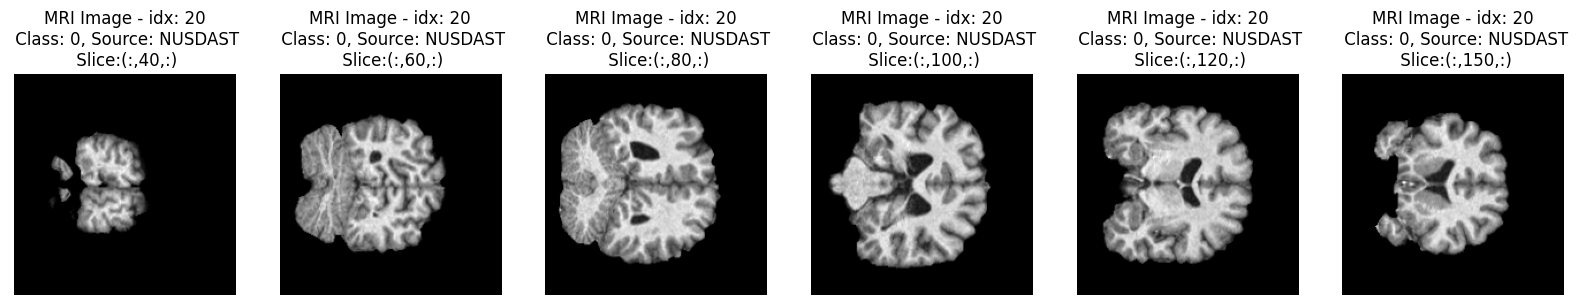

Displaying slices from image index: 40


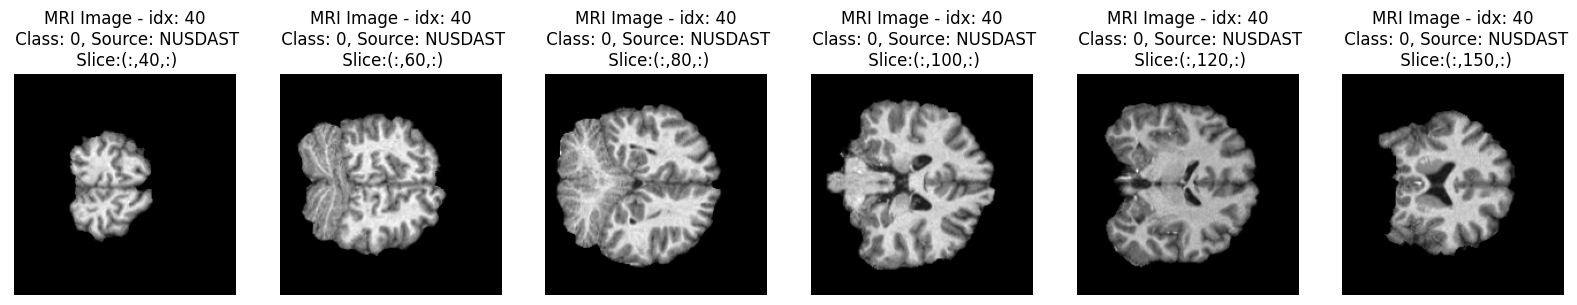

Displaying slices from image index: 60


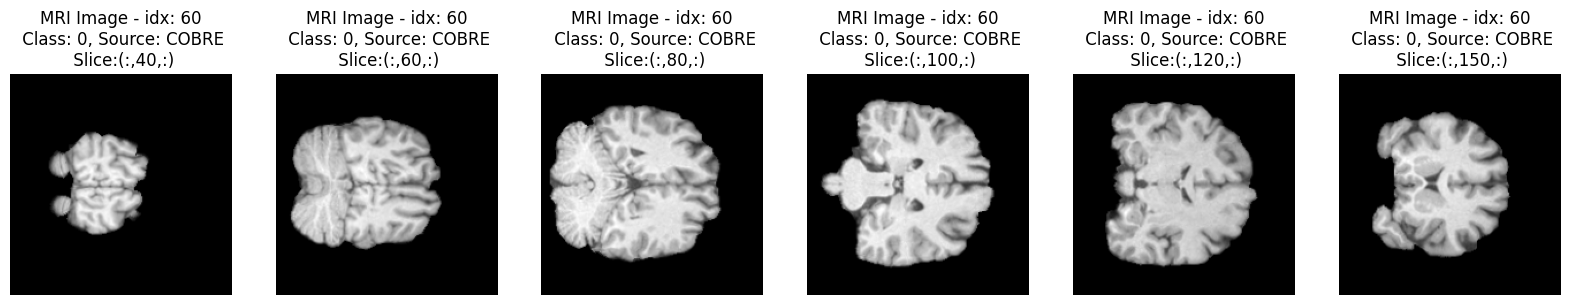

In [6]:
# Assuming list_slices is a list of slice indices you want to present
ids_to_present = [20, 40, 60]
list_slices = [40, 60, 80, 100, 120, 150]  # Example list of slices

for id_of_image_to_present in ids_to_present:
  print("Displaying slices from image index:",id_of_image_to_present)
  img_data, fold, source, category = dataset[id_of_image_to_present]
  plt.figure(figsize=(20, 5))  # Adjust figure size as needed
  for i, slice_index in enumerate(list_slices):
      slice_data = img_data[:, slice_index, :]  # Extract the slice data
      plt.subplot(1, len(list_slices), i + 1)
      plt.imshow(slice_data, cmap='gray')
      plt.axis('off')  # Turn off axis labels
      plt.title(f'MRI Image - idx: {id_of_image_to_present}\n Class: {category}, Source: {source}\n Slice:(:,{slice_index},:)')
      plt.xlabel(f"Slice: {slice_index}")
  plt.show()

Displaying slices from image index: 20


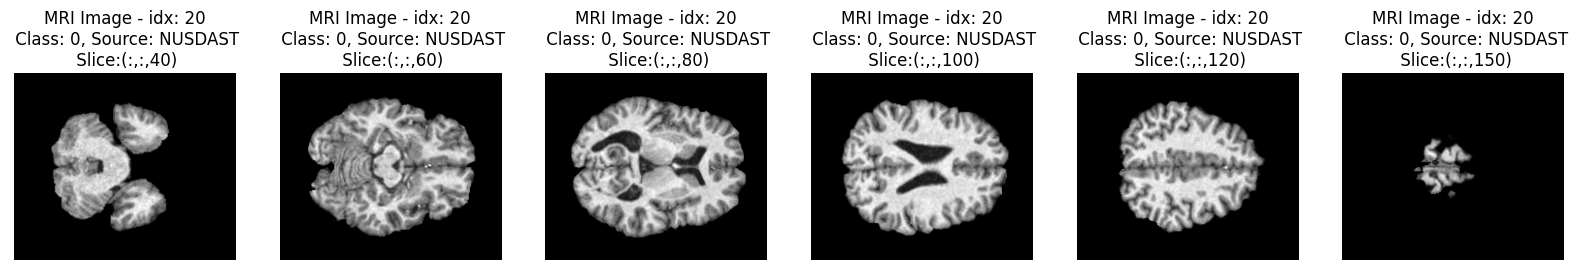

Displaying slices from image index: 40


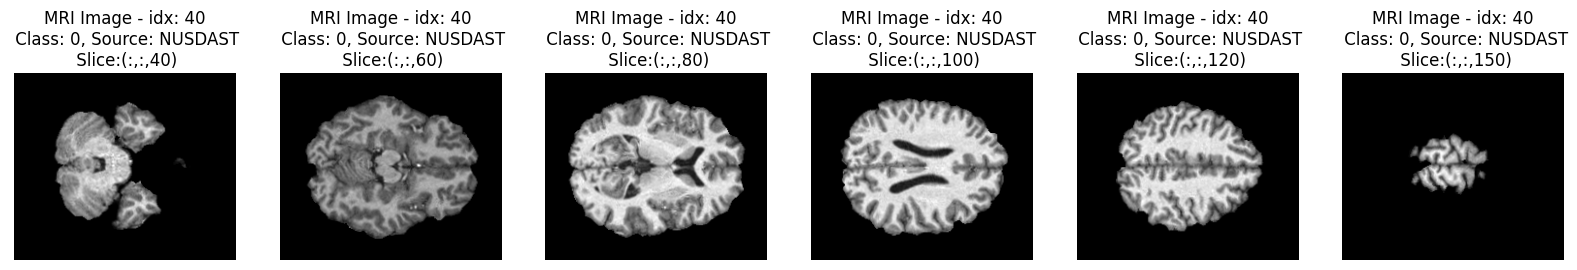

Displaying slices from image index: 60


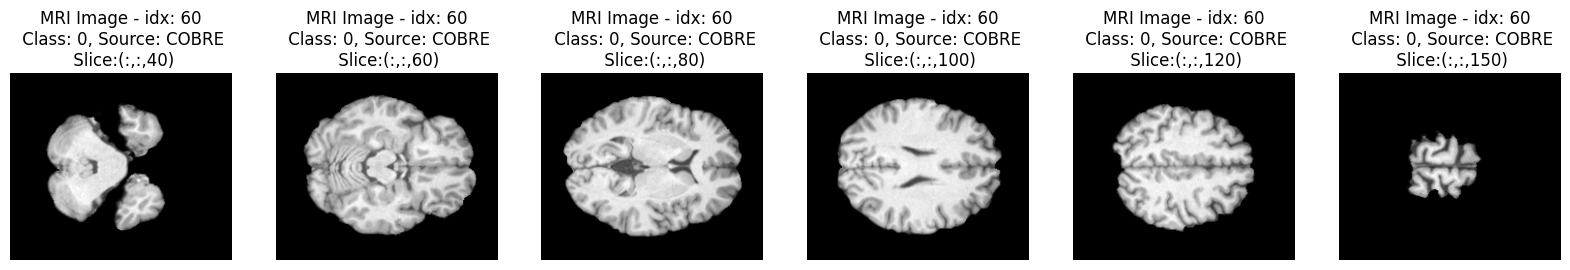

In [7]:
# Assuming list_slices is a list of slice indices you want to present
ids_to_present = [20, 40, 60]
list_slices = [40, 60, 80, 100, 120, 150]  # Example list of slices

for id_of_image_to_present in ids_to_present:
  print("Displaying slices from image index:",id_of_image_to_present)
  img_data, fold, source, category = dataset[id_of_image_to_present]
  plt.figure(figsize=(20, 5))  # Adjust figure size as needed
  for i, slice_index in enumerate(list_slices):
      slice_data = img_data[:, :, slice_index]  # Extract the slice data
      plt.subplot(1, len(list_slices), i + 1)
      plt.imshow(slice_data, cmap='gray')
      plt.axis('off')  # Turn off axis labels
      plt.title(f'MRI Image - idx: {id_of_image_to_present}\n Class: {category}, Source: {source}\n Slice:(:,:,{slice_index})')
      plt.xlabel(f"Slice: {slice_index}")
  plt.show()

Main take away:
We can see that for all the 3 angles, some of the slices are redundent: there is nothing in the image (only black pixels). Therefore, we would like to remove them for our model